### Spectral Modularity Partitioning

The purpose of this tutorial is to explore the spectral cut method for partitioning a network into two communities. The problem to be solved is to partition the vertices of a network in such a way that the modularity metric is maximized. In class, we observed that it is not computationally practical to search through all possible ways of partitioning nodes into two classes (or _shores_ as they were described in class), so we have to find ways to approximate the optimal solution. 

The spectral cut method seeks to find a partition into two classes that maximizes the modularity metric

$$ Q({\rm partition}) = \frac{1}{2m} \sum_{i,j\in V} \left[A_{i,j} - \frac{k_ik_j}{2m}\right] \delta_(c_i,c_j) $$

The _modularity matrix_ was defined using the core part of the definition of the modularity metric,

$$ B_{ij} = A_{ij} - \frac{k_ik_j}{2m}$$

In matrix form, the modularity matrix is therefore defined as

$$ B = A - {\mathbf k}{\mathbf k}^T $$

where ${\mathbf k}$ is the column vector made up of the degrees of each vertex.


We were able to turn the maximization problem into an eigenvalue problem by
- changing the $\delta$ function in the modularity metric into a function that assigned each vertex to a positive shore (with value $+1$) and a negative shore (with value $-1$)
- allowing values other than $+1$ and $-1$
- adding a constraint on the values
- formulating a Lagrange multiplier problem
- taking the derivative of the Lagrange multiple equation, setting it to zero, and solving

These steps are summarized as

$$ \begin{array}{rcl}
    {\rm maximize} & Q({\rm partition}) & \Rightarrow \\
    {\rm maximize} & {\mathbf x}^T B {\mathbf x} & \Rightarrow \\
    {\rm solve} & B{\mathbf x} = \lambda{\mathbf x}
\end{array} $$

---


**Leading Eigenvalue**

Which eigenvector maximizes ${\mathbf x}^T B {\mathbf x}$? Observe that since ${\mathbf x}$ and $\lambda$ are solutions of to the eigenvalue equation $B{\mathbf x} = \lambda{\mathbf x}$, we can write  

$$ \begin{array}{rcl}
{\mathbf x}^T B {\mathbf x} &=& {\mathbf x}^T \big(B {\mathbf x}\big) \\
&=& {\mathbf x}^T \big(\lambda {\mathbf x}\big) \\
&=& \lambda {\mathbf x}^T {\mathbf x}
\end{array}
$$

The last line of these equations shows that the modularity is maximized when we choose the largest value of $\lambda$ and its corresponding eigenvecteor. The eigenvector corresponding to the largest eigenvalue is called the _leading eigenvector_.

---

This tutorial will explore what the algorithm does and explain how the eigenvector used in the spectral cut algorithm differs from the other eigenvector problem we've seen, namey the eigenvector centrality problem. 

As usual, we'll begin by defining some visualization functions.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import networkx as nx
import numpy as np
from numpy.typing import NDArray
from typing import Hashable, Tuple, Set, List

def get_NCM_Figure3_14() -> Tuple[nx.Graph, dict[Hashable, Tuple[float, float]]]:
    """
        Figure 3.14 from the book Networks, Crowds, and Markets is a useful
        example graph. This function returns this figure as a networkx Graph
        and a position dictionary for the neato layout
    """
    G: nx.Graph = nx.Graph()
    G.add_nodes_from(range(0,14))
    G.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(8,9),(8,10),(9,10),(11,12),(11,13),(12,13),(2,6),(5,6),(7,8),(7,11),(6,7)])
    pos: dict[Hashable, Tuple[float, float]] = nx.nx_pydot.graphviz_layout(G,prog='neato')
    return G, pos

def draw_edge_by_type(G: nx.Graph, 
                      pos: dict[Hashable, Tuple[float, float]], 
                      edge: Tuple[Hashable, Hashable], 
                      partition: Tuple[Set, ...]
                      ) -> None:
    """
        Draw edges between nodes in different partitions using dashed lines.
        Draw edges between nodes within the same partition using solid lines.
    """
    edge_style = 'dashed'
    for part in partition:
        if edge[0] in part and edge[1] in part:
            edge_style = 'solid'
            break
    nx.draw_networkx_edges(G, pos, edgelist=[edge], style = edge_style)

def show_partitions(G: nx.Graph,
                    partition: Tuple[Set, ...], 
                    pos: dict[Hashable, Tuple[float, float]] | None = None,
                    title = ""
                    ) -> None:
    """ 
        Show the networkx graph with colors and edges indicating properties
        of the partition

        Edges:
        • Dashed lines indicate edges between nodes in different partitions
        • Solid lines indicate edges between nodes in the same partition

        Nodes:
        • All nodes in the same partition get mapped to the same color
        • When there are more partitions than ther are in the color pallette, repeat colors
    """
    #color_list = ['c','m','y','g','r']
    color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'lightpink', 'lightgray', 'linen']
    plt.clf()
    ax: Axes = plt.gca()
    if pos is None: 
        pos = nx.spring_layout(G, seed = 0)
    for i in range(len(partition)):
        nx.draw_networkx_nodes(partition[i],pos,node_color=color_list[i%len(color_list)], alpha = 0.8)
    for edge in G.edges:
        draw_edge_by_type(G, pos, edge, partition)
    nx.draw_networkx_labels(G,pos)
    if len(G.edges) == 0:
        mod = 0
    else:
        mod = nx.algorithms.community.quality.modularity(G,partition)
    title = title + " Modularity = " + str(np.round(mod,2))

    ax.set_title(title)
    ax.set_axis_off()

Let's show the network we'll use to illustrate the ideas. 

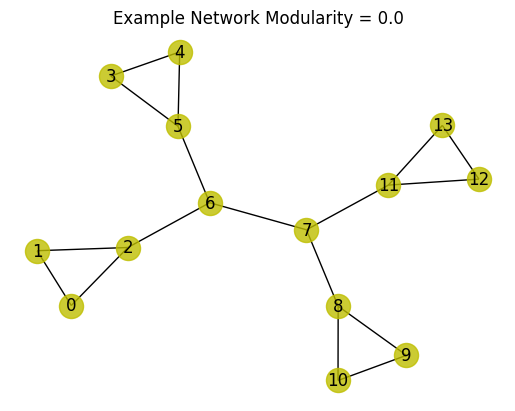

In [3]:
G, pos = get_NCM_Figure3_14()
show_partitions(G, 
                partition = [list(G.nodes),[]], 
                pos=pos,
                title = "Example Network")


---

**Spectral Methods**

We are using eigenvectors and eigenvalues to solve the spectral modularity cut problem. It's easy to blend terminology from the other problem in class that used eigenvectors and eignvalues: eigenvector centrality. 

The key distinction between the eigenvectors used in the spectral modularity cut problem and the eigenvectors used in the eigenvector centrality problem is the matrix.
- The spectral cut problem uses an eigenvector from the modularity matrix $B$
- The eigenvector centrality problem uses an eigenvector from the adjacency matrix $A$

Let's compare these two matrices because their structures have a big impact on which eigenvectors are useful. Note that Networkx has a method that returns the modularity matrix.

---

**Principal Eigenvector**

In [4]:
############
## Cell 1 ##
############
A: NDArray = nx.adjacency_matrix(G, 
                                  nodelist=[node for node in sorted(G.nodes)]
                                  ).toarray()  # nx.adjacency matrix returns a sparse matrix. Convert to array
print(f"Adjacency matrix is {A}")

Adjacency matrix is [[0 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0]]


In the eigenvector centrality problem, we wanted all vertices to have non-negative centrality. When the graph is connected, the Perron Frobenious theorem guaranteed that the eigenvalue with highest modulus corresponded to an eigenvector with all non-negative values. We wrote a function that found that eigenvector and eigenvalue.

In [5]:
############
## Cell 2 ##
############
def get_principal_eigen(M: np.array) -> Tuple[float, NDArray]:
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(M)

    # Find the index of the principal eigenvalue (the largest eigenvalue)
    principal_eigenvalue_index = np.argmax(eigenvalues)

    # Get the principal eigenvalue
    principal_eigenvalue = eigenvalues[principal_eigenvalue_index]

    # Get the principal eigenvector
    principal_eigenvector = eigenvectors[:, principal_eigenvalue_index]
    return principal_eigenvalue, principal_eigenvector

principal_eigenvalue, principal_eigenvector = get_principal_eigen(A)
print(f"The principal eigenvalue of A is {np.round(principal_eigenvalue,2)}")
print(f"The principal eigenvector of A is\n   {np.round(principal_eigenvector,2)}")

The principal eigenvalue of A is 2.56
The principal eigenvector of A is
   [0.2  0.2  0.31 0.2  0.2  0.31 0.39 0.39 0.31 0.2  0.2  0.31 0.2  0.2 ]


Why are all the values of the principal eigenvector non-negative?

---

In [ ]:
############
## Cell 3 ##
############

B: NDArray = nx.modularity_matrix(G, 
                                  nodelist=[node for node in sorted(G.nodes)])
print(f"Modularity matrix is\n{B}")


print(B[0,:]) # First row
print(f"There are {len(G.edges)} edges in the network")
print(f"Matrix entry (0,0) = 0- (k_0 k_0)/2m = {-2*2/(2*len(G.edges))}")
print(f"Matrix entry (0,1) = 1- (k_0 k_1)/2m = {1-2*2/(2*len(G.edges))}")

Modularity matrix is
[[-1.64102564  0.07692308 -0.02564103 ...  0.38461538 -1.23076923
  -1.74358974]
 [ 0.07692308 -0.51923077  0.42307692 ... -0.34615385 -0.69230769
  -0.98076923]
 [-0.02564103  0.42307692 -0.64102564 ... -0.38461538  0.23076923
  -1.08974359]
 ...
 [ 0.38461538 -0.34615385 -0.38461538 ... -0.23076923  0.53846154
   0.34615385]
 [-1.23076923 -0.69230769  0.23076923 ...  0.53846154 -0.92307692
  -0.30769231]
 [-1.74358974 -0.98076923 -1.08974359 ...  0.34615385 -0.30769231
  -1.8525641 ]]
[-1.64102564  0.07692308 -0.02564103  0.38461538  0.69230769  0.58974359
  0.58974359  0.58974359  0.48717949 -0.20512821  0.69230769  0.8974359
  0.79487179  0.48717949 -0.20512821 -0.20512821 -0.20512821  0.79487179
 -0.20512821  0.69230769 -0.20512821  0.79487179 -0.20512821 -0.51282051
 -0.30769231 -0.30769231 -0.20512821 -0.41025641 -0.30769231 -0.41025641
 -0.41025641  0.38461538 -1.23076923 -1.74358974]
There are 78 edges in the network
Matrix entry (0,0) = 0- (k_0 k_0)/2m = 

Notice how the modularity matrix has both positive and negative values, but the adjacency matrix has only positive values. This difference between the elements of the matrices has an important impact on the eigenvectors. Before discussing what the impact is, let's do a quick review of why the modularity matrix has both positive and negative values.

Recall that the modularity matrix is defined as

$$ B_{ij} = A_{ij} - \frac{k_ik_j}{2m}$$

Let's look at the first two entries in the top row of the modularity matrix.

The first element is negative, which makes sense in terms of the definition of the modularity matrix because 
- $A_{0,0} = 0$ (no self loops), and 
- $k_0=2$ which means that $\frac{k_0 k_0}{2m} = (2*2)/(2*17) = 0.1176$.

The second element is positive, which is
- $A_{0,1} = 1$ since node 0 is connected to node 1
- $k_0 = 2$ and $k_1= 2$, which means that $\frac{k_0 k_1}{2m} = (2*2)/(2*17) = 0.1176$.
- The difference is $0.8824$.

---

What happens if we try to try to find the principal eigenvector for the modularity matrix?

In [7]:
############
## Cell 4 ##
############
principal_eigenvalue, principal_eigenvector = get_principal_eigen(B)
print(f"The principal eigenvalue of B is {np.round(principal_eigenvalue,2)}")
print(f"The principal eigenvector of B is\n   {np.round(principal_eigenvector,2)}")

The principal eigenvalue of B is 2.24
The principal eigenvector of B is
   [-0.26 -0.26 -0.32 -0.26 -0.26 -0.32 -0.2   0.2   0.32  0.26  0.26  0.32
  0.26  0.26]


The eigenvector has both positive and negative values. Why aren't all the values of the eigenvector positive? Because the modularity matrix $B$ does not satisfy the conditions of the Perron-Frobenius theorem. This means that the terms _principal eigenvalue_ and _principal eigenvector_ are not defined for the modularity matrix. We need a different definition. 

---


**Leading Eigenvector**

Recall that we are trying to maximize ${\mathbf x}^TB{\mathbf x}$ (subject to the constraint on ${\mathbf x}$ that keeps these values from being too high). Let's plug in the fact that ${\mathbf x}$ is an eigenvector. Then the solution that maximizes ${\mathbf x}^TB{\mathbf x}$ can be written as $\lambda{\mathbf x}$ (taking advantage of the fact that $B$ is symmetric). The maximum therefore occurs when $\lambda$ is the largest positive eigenvalue.  (Caution: Microsoft Copilot halucinated an incorrect interpretation of which eigenvalue is best.)

The largest positive eigenvalue has a name. It is called the _leading eigenvector_. 

Note that we've been finding partitions only of undirected networks. Consequently, $B=B^T$, which means that all the eigenvalues of $B$ are real. (Later on in the class, we'll probably discuss the theorem that states that the eigenvalues of a real symmetric matrix are real.)

Let's look at the eigenvalues and eigenvectors of $B$ to get a sense of their properties.

In [8]:
[vals, vecs] = np.linalg.eig(B)
print(f"eigenvalues of B are\n {np.round(vals,2)}")

eigenvalues of B are
 [-2.24 -1.58  0.    1.05  2.24  2.    2.   -0.   -1.   -1.   -1.   -1.
 -1.   -1.  ]


Let's select the eigenvector that corresponds to the leading eigenvalue. (Code from Copilot.)

In [9]:
def get_leading_eigenvector(G: nx.Graph
                            ) -> Tuple[float, List[float]]:
    B: NDArray = nx.modularity_matrix(G)
    eigenvalues, eigenvectors = np.linalg.eig(B)
    largest_eigenvalue_index = np.argmax(eigenvalues)
    largest_eigenvalue = eigenvalues[largest_eigenvalue_index]
    leading_eigenvector = eigenvectors[:, largest_eigenvalue_index]
    return largest_eigenvalue, leading_eigenvector

largest_eigenvalue, leading_eigenvector = get_leading_eigenvector(G)
print("Largest Eigenvalue:", np.round(largest_eigenvalue,2))
print("Leading Eigenvector:", np.round(leading_eigenvector,2))

Largest Eigenvalue: 2.24
Leading Eigenvector: [-0.26 -0.26 -0.32 -0.26 -0.26 -0.32 -0.2   0.2   0.32  0.26  0.26  0.32
  0.26  0.26]


The rule we derived in class for turning the values in the leading eigenvector into the $s_i$ values is:

$$ 
s_i = \left\{
    \begin{array}{ll}
        1 & {\rm if\ } x_i  \geq 0 \\
        0 & {\rm otherwise}
    \end{array}
\right. 
$$

Vertices are therefore assigned to a shore using

$$ v_i \in \left\{ 
    \begin{array}{cl}
        {\rm shore\_1} & {\rm if\ } x_i \geq 0 \\
        {\rm shore\_2} & {\rm otherwise}
    \end{array}
\right. $$

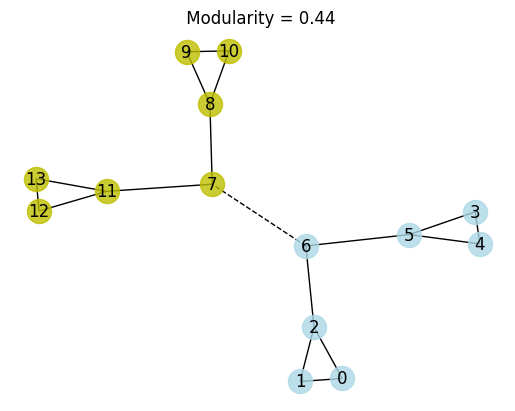

In [10]:
def get_shores_from_eigenvector(x):
    shore1 = set()
    shore2 = set()
    for node in G.nodes:
        if x[node] >= 0: 
            shore1.add(node)
        else: 
            shore2.add(node)
    return [shore1, shore2]
partitions = get_shores_from_eigenvector(leading_eigenvector)
show_partitions(G, partitions)

---

Let's apply the code to find the partition for a path graph.

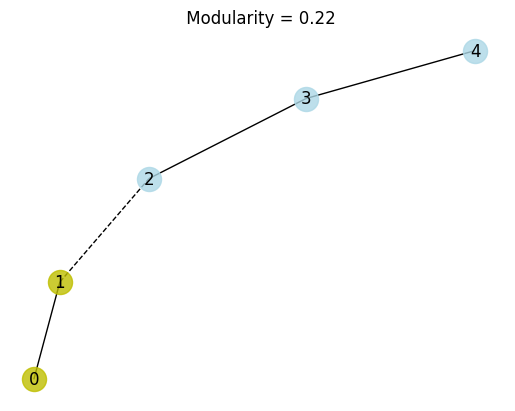

In [11]:
G = nx.path_graph(5)
largest_eigenvalue, leading_eigenvector = get_leading_eigenvector(G)
partitions = get_shores_from_eigenvector(leading_eigenvector)
show_partitions(G, partitions)

---

Let's now repeat for the karate club graph. Begin with some helper functions.

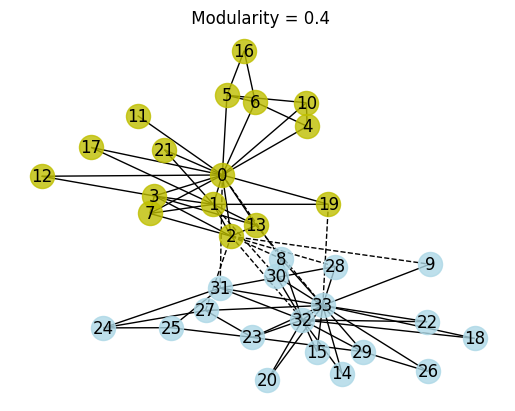

In [12]:
G = nx.karate_club_graph()
largest_eigenvalue, leading_eigenvector = get_leading_eigenvector(G)
partitions = get_shores_from_eigenvector(leading_eigenvector)
show_partitions(G, partitions)

[[-0.25  0.5  -0.25]
 [ 0.5  -1.    0.5 ]
 [-0.25  0.5  -0.25]]


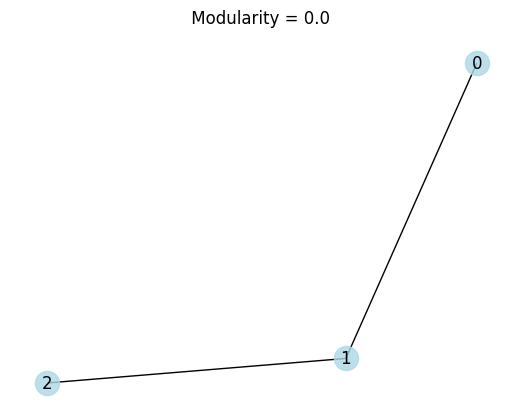

In [16]:
G = nx.path_graph(3)
show_partitions(G, [set(), set(G.nodes())])
B = nx.modularity_matrix(G)
print(B)